In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from utils import *

W0826 08:59:48.594620 4623287744 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



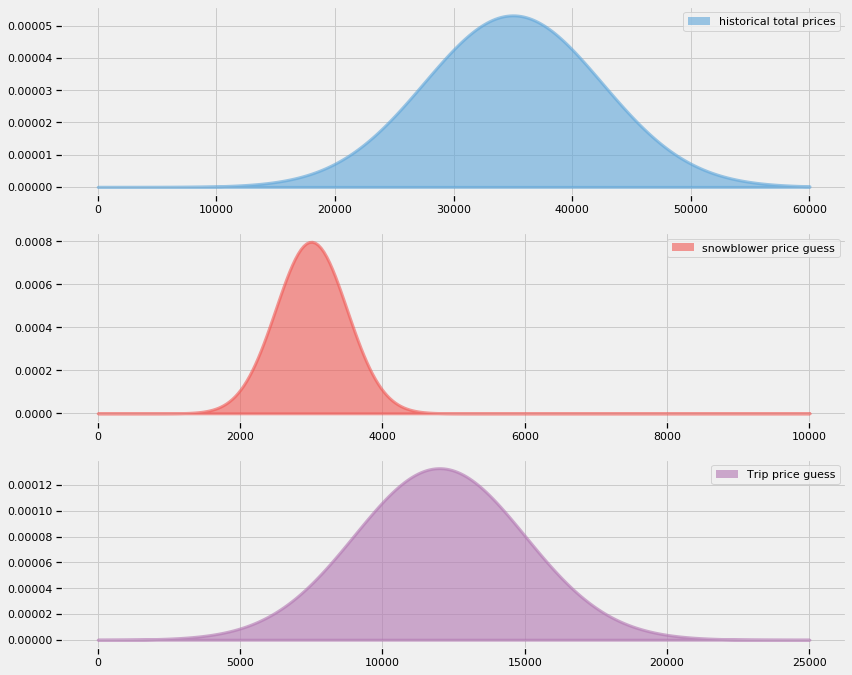

In [3]:
plt.figure(figsize=(12.5, 11))

plt.subplot(311)
x1 = tf.linspace(start=0., stop=60000., num=250)
x2 = tf.linspace(start=0., stop=10000., num=250)
x3 = tf.linspace(start=0., stop=25000., num=250)

historical_prices = tfd.Normal(loc=35000., scale=7500.).prob(x1)
snowblower_price_guesses = tfd.Normal(loc=3000., scale=500.).prob(x2)
trip_price_guess = tfd.Normal(loc=12000., scale=3000.).prob(x3)

[
    x1_, x2_, x3_,
    historical_prices_, snowblower_price_guesses_, trip_price_guess_,
] = evaluate([
    x1, x2, x3,
    historical_prices, snowblower_price_guesses, trip_price_guess
])

sp1 = plt.fill_between(x1_, 0, historical_prices_, color=TFColor[3], lw=3,
                      alpha=0.6, label='historical total prices')

p1 = plt.Rectangle((0, 0), 1, 1, fc=sp1.get_facecolor()[0])
plt.legend([p1], [sp1.get_label()])

plt.subplot(312)
sp2 = plt.fill_between(x2_, 0, snowblower_price_guesses_, color=TFColor[0],
                      lw=3, alpha=0.6, label='snowblower price guess')

p2 = plt.Rectangle((0, 0), 1, 1, fc=sp2.get_facecolor()[0])
plt.legend([p2], [sp2.get_label()])

plt.subplot(313)
sp3 = plt.fill_between(x3_, 0, trip_price_guess_, color=TFColor[6], lw=3,
                      alpha=0.6, label='Trip price guess')
p3 = plt.Rectangle((0, 0), 1, 1, fc=sp3.get_facecolor()[0])
plt.legend([p3], [sp3.get_label()]);

### Bayesian Point Estimate
Suppose $P(\theta|X)$ is the posterior distribution of $\theta$ after observing data $X$, then the following function is understandable as the *expected loss of choosing estimate $\hat{\theta}$ to estimate $\theta$*:

$$
l(\hat{\theta}) = E_{\theta}[L(\theta,\hat{\theta})]
$$
This is also known as the *risk* of estimate $\hat{\theta}$. The subscript $\theta$ under the expectation symbol is used to denote that $\theta$ is the unknown (random) variable in the expectation, something that at first can be difficult to consider.

We spent all of last chapter discussing how to approximate expected values. Given $N$ samples $\theta_i$, $i=1,\ldots,N$ from the posterior distribution, and a loss function $L$, we can approximate the expected loss of using estimate $\hat{\theta}$ by the Law of Large Numbers:

$$
\frac{1}{N}\sum_{i=1}^N L(\theta_i, \hat{\theta})\approx E_{\theta}[L(\theta, \hat{\theta})] = l(\hat{\theta})
$$

Notice that measuring your loss via an *expected value* uses more information from the distribution than the MAP estimate which will only find the maximum value of the distribution and ignore the shape of the distribution. Ignoring information can over-expose youself to tail risks, like the unlikely hurricane, and leaves your estimate ignorant of how ignorant you really are about the parameter.

Similarly, compare this with frequentist methods, that traditionally only aim to minimize the error, and do not consider the *loss associated with the result of that error*. Compound this with the fact that frequentist methods are almost guaranteed to never be absolutely accurate. Bayesian point estimates fix this by planning ahead: your estimate is going to be wrong, you might as well err on the right side of wrong.

### Example

In [3]:
data_mu = [3000., 12000.]
data_std = [500., 3000.]

mu_prior = 35000.
std_prior = 750.

number_of_steps = 50000
burnin = 10000

def posterior_log_prob(true_price, prize_1, prize_2):
    """
    Our posterior log probability, as a function of states
    
    Parameters
    ----------
    true_price_: scalar
        True price estimate, taken from state
    prize_1_: scalar
        Prize 1 estimate, to be added to the prize 1 estimate, taken from state
    prize_2_: scalar
        Prize 2 estimate, to be added to the prize 1 estimate, taken from state
        
    Returns
    -------
    Scalar sum of log probabilities.
    
    Closure over: data_mu, data_std, mu_prior, std_prior
    """
    rv_true_price = tfd.Normal(loc=mu_prior,
                              scale=std_prior,
                              name='true_price')
    rv_prize_1 = tfd.Normal(loc=data_mu[0],
                           scale=data_std[0],
                           name='first_prize')
    rv_prize_2 = tfd.Normal(loc=data_mu[1],
                           scale=data_std[1],
                           name='second_prize')
    
    price_estimate = prize_1 + prize_2
    
    error = tfd.Normal(loc=price_estimate, scale=3000.,name='error')
    
    return (
        rv_true_price.log_prob(true_price) + 
        rv_prize_1.log_prob(prize_1) + 
        rv_prize_2.log_prob(prize_2) +
        error.log_prob(true_price)
    )

In [4]:
[
    true_price,
    prize_1,
    prize_2
], kernel_results = tfp.mcmc.sample_chain(
    num_results=number_of_steps,
    num_burnin_steps=burnin,
    current_state=[
        tf.fill([1], 20000., name='init_true_price'),
        tf.fill([1], 3000., name='init_prize_1'),
        tf.fill([1], 12000., name='init_prize_2')
    ],
    kernel=tfp.mcmc.RandomWalkMetropolis(
        target_log_prob_fn=posterior_log_prob,
        seed=54),
    parallel_iterations=1,
    name='MCMC_eval'
)

# Some of the steps of the MCMC will involve just getting close to where the right answers are
# so we get the samples random walk, and cut off the trial (or `burn_in`) steps
burned_true_price_traces = tf.stack(tf.map_fn(lambda x: x[0], true_price), axis=0)[burnin:]

# We'll take the mean and standard deviations of the samples to put
# together the approximate posterior distribution for the true price.
# We'll also get 50,000 samples from the approximate posterior distribution
posterior_price_predictive_samples = tfd.Normal(loc=tf.reduce_mean(burned_true_price_traces, axis=0),
                                               scale=3750.,
                                               name='approx_posterior').sample(sample_shape=50000)

W0826 09:09:03.705703 4623287744 deprecation.py:323] From /Users/sueliu/projects/personal-study/Bayesian-Methods-for-Hackers/.venv/lib/python3.7/site-packages/tensorflow_probability/python/mcmc/internal/util.py:164: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [5]:
[
    posterior_price_predictive_samples_,
    kernel_results_,
] = evaluate([
    posterior_price_predictive_samples,
    kernel_results,
])

print('acceptance rate: {}'.format(
    kernel_results_.is_accepted.mean()))

print('posterior_price_predictive_sample_ trace:',
    posterior_price_predictive_samples_)

acceptance rate: 0.99094
posterior_price_predictive_sample_ trace: [23824.947 17875.348 17522.459 ... 20288.91  19511.635 18069.783]


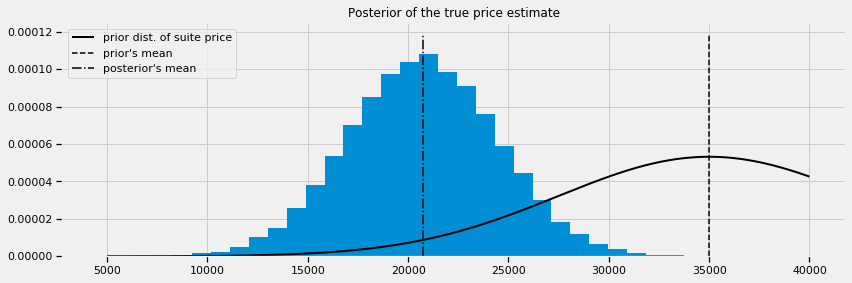

In [6]:
plt.figure(figsize=(12.5, 4))
prices = tf.linspace(start=5000., stop=40000., num=35000)
prior = tfd.Normal(loc=35000., scale=7500.).prob(prices)

[
    prices_, prior_,
] = evaluate([
    prices, prior
])

plt.plot(prices_, prior_, c='k', lw=2,
        label='prior dist. of suite price')

hist = plt.hist(posterior_price_predictive_samples_, bins=35, normed=True, histtype='stepfilled')
plt.title('Posterior of the true price estimate')
plt.vlines(mu_prior, 0, 1.1 * np.max(hist[0]), label="prior's mean",
          linestyles='--')
plt.vlines(posterior_price_predictive_samples_.mean(), 0, 1.1*np.max(hist[0]),
          label="posterior's mean", linestyles="-.")
plt.legend(loc='upper left');

Notice that because of our two observed prizes and subsequent guesses (including uncertainty about those guesses), we shifted our mean price estimate down about \$15,000 dollars from the previous mean price.

A frequentist, seeing the two prizes and having the same beliefs about their prices, would bid $\mu_1 + \mu_2 = 35000$, regardless of any uncertainty. Meanwhile, the naive Bayesian would simply pick the mean of the posterior distribution. But we have more information about our eventual outcomes; we should incorporate this into our bid. We will use the loss function above to find the best bid (best according to our loss).

What might a contestant's loss function look like? I would think it would look something like:

```python
def showcase_loss(guess, true_price, risk=80000):
    if true_price < guess:
        return risk
    elif abs(true_price - guess) <= 250:
        return -2*np.abs(true_price)
    else:
        return np.abs(true_price - guess - 250)
```
where `risk` is a parameter that defines how bad it is if your guess is over the true price. A lower `risk` means that you are more comfortable with the idea of going over. If we do bid under and the difference is less than \$250, we receive both prizes (modelled here as receiving twice the original prize). Otherwise, when we bid under the `true_price` we want to be as close as possible, hence the `else` loss is an increasing function of the distance between the guess and true price.

For every possible bid, we calculate the *expected loss* associated with that bid. We vary the `risk` parameter to see how it affects our loss:

In [7]:
def showdown_loss(guess, true_price, risk, name=None):
    """Stock loss function.
    
    Parameters
    ----------
    guess: float32 Tensor of size ()
        Samples from a range of guesses to loop through
    true_price: float32 Tensor of size (50000,)
        The price from the HMC sampling. This is the full array of samples.
    risk: Tensor of size()
        Penalizer for a score going over (lower risk indicates more comfort
        with price going over)
        
    Returns
    -------
    Loss: array of shape (50000,) the absolute value of the difference between
    `guess_` and `true_price`
    """
    guess = tf.convert_to_tensor(guess, name='guess')
    true_price = tf.convert_to_tensor(true_price, name='true_price')
    risk = tf.convert_to_tensor(risk, name='risk')
    loss = tf.maximum(true_price - tf.to_float(guess), 0)
    loss = tf.where(tf.abs(true_price - tf.to_float(guess)) <= 250.,
                   -2. * true_price * tf.ones_like(tf.to_float(guess)),
                   loss)
    loss = tf.where((true_price < tf.to_float(guess))| tf.zeros_like(risk, dtype=tf.bool),
                   risk + tf.zeros_like(loss),
                   loss + tf.zeros_like(risk))
    
    return loss

<Figure size 900x360 with 0 Axes>

W0826 09:51:40.229784 4623287744 deprecation.py:323] From <ipython-input-7-a6a44cc56a25>:24: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.


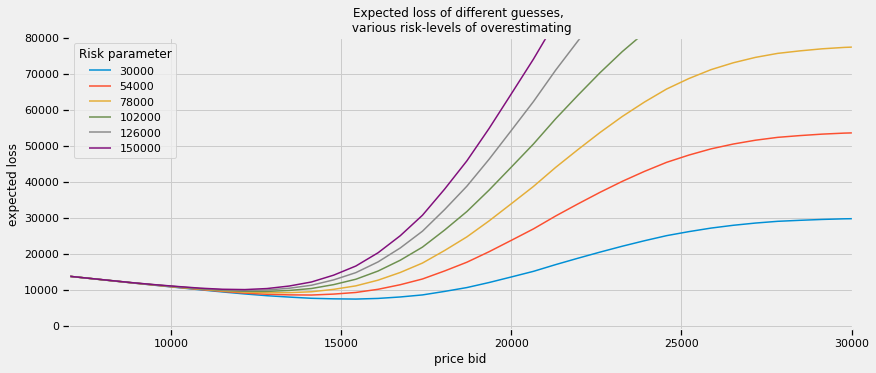

In [8]:
plt.figure(figsize=(12.5, 5))


guesses = tf.linspace(5000., 50000., 70)
risks = tf.linspace(30000., 150000., 6)
[ guesses_, risks_ ] = evaluate([guesses, risks])

expected_loss = lambda guess_, risks_: tf.reduce_mean(
    showdown_loss(guess_, posterior_price_predictive_samples_, risks_))

results = []
for p in risks_:
    results = evaluate([expected_loss(g, p) for g in guesses_])
    plt.plot(guesses_, results, label="%d" % p)
    
plt.title('Expected loss of different guesses, \n various risk-levels of overestimating')
plt.legend(loc='upper left', title='Risk parameter')
plt.xlabel('price bid')
plt.ylabel('expected loss')
plt.xlim(7000, 30000)
plt.ylim(-1000, 80000);

### Minimizing our losses
It would be wise to choose the estimate that minimizes our expected loss. This corresponds to the minimum point on each of the curves above. More formally, we would like to minimize our expected loss by finding the solution to 
$$
\mathrm{argmin}_{\hat{\theta}}E_\theta\left[L(\theta,\hat{\theta})\right]
$$
The minimum of the expected loss is called the *Bayes action*.

We'll compute the minimum loss for the *Showcase* example above:

minimum at risk 30000: 14950.00
minimum at risk 54000: 13863.13
minimum at risk 78000: 12795.36
minimum at risk 102000: 12693.43
minimum at risk 126000: 12152.58
minimum at risk 150000: 11979.00


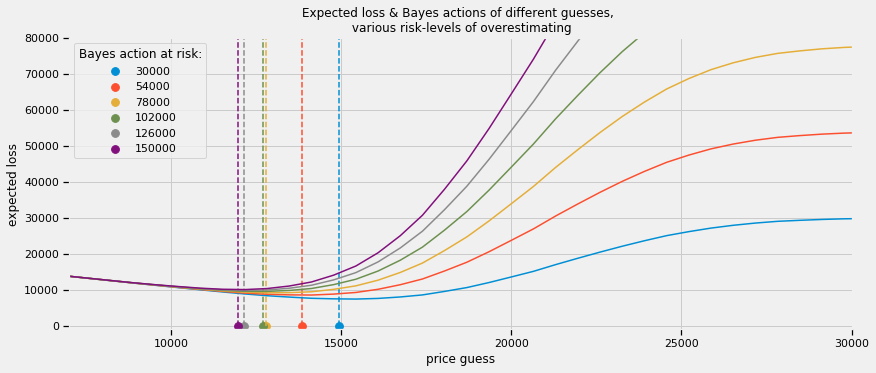

In [11]:
plt.figure(figsize=(12.5, 5))

ax = plt.subplot(111)

for _p in risks_:
    color_ = next(ax._get_lines.prop_cycler)
    results_ = evaluate([expected_loss(g_, _p) for g_ in guesses_])
    _g = tf.Variable(15000., trainable=True)
    loss = -expected_loss(_g, _p)
    optimizer = tf.train.AdamOptimizer(10)
    opt_min = optimizer.minimize(loss, var_list=[_g])
    evaluate(tf.global_variables_initializer())
    min_losses = []
    min_vals = []
    for i in range(500):
        _, l, value_ = evaluate([opt_min, loss, _g])
        min_losses.append(l)
        min_vals.append(value_)
    min_losses = np.asarray(min_losses)
    min_vals = np.asarray(min_vals)
    min_results_ = min_vals[np.argmax(min_losses)]

    plt.plot(guesses_, results_ , color = color_['color'])
    plt.scatter(min_results_, 0, s = 60, \
                color= color_['color'], label = "%d"%_p)
    plt.vlines((min_results_), 0, 120000, color = color_['color'], linestyles="--")
    print("minimum at risk %d: %.2f" % (_p, (min_results_)))
                                    
plt.title("Expected loss & Bayes actions of different guesses, \n \
various risk-levels of overestimating")
plt.legend(loc="upper left", scatterpoints = 1, title = "Bayes action at risk:")
plt.xlabel("price guess")
plt.ylabel("expected loss")
plt.xlim(7000, 30000)
plt.ylim(-1000, 80000);

### Shortcuts
For some loss functions, the Bayes action is known in closed form. We list some of them below:
* If using the mean-squared loss, the Bayes action is the mean of the posterior distribution. i.e. the value $E_\theta[\theta]$ minimizes $E_\theta[(\theta - \hat{\theta})^2]$. Computationally this requires us to calculate the average of the posterior samples.
* Where as the *median* of the posterior distribution minimizes the expected absolute-loss. The sample median of the posterior samples is an appropriate and very accurate approximation to the true median.
* In fact, it is possible to show that the MAP estimate is the solution to using a loss function that shrinks to the zero-one loss.

## Financial prediction

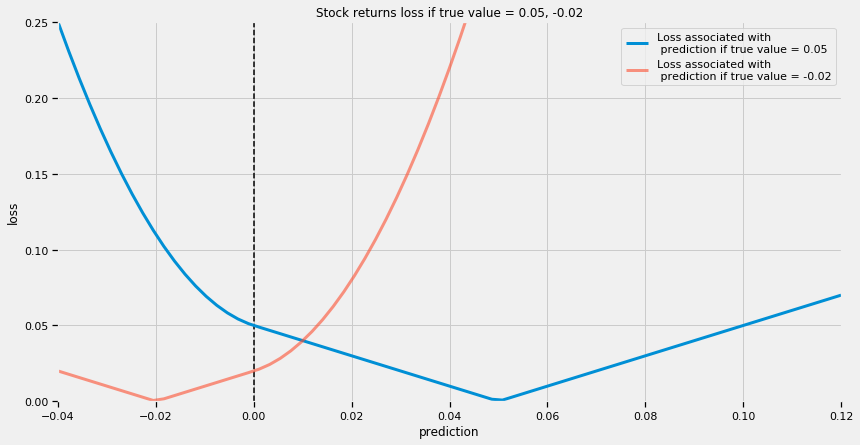

In [12]:
plt.figure(figsize=(12.5, 6.5))
reset_sess()

def stock_loss(true_return, yhat, alpha=100.):
    """
    Stock loss function
    
    Parameters
    ----------
    true_return: float32 Tensor
        True stock return
    yhat: float32
    alpha: float32
    
    Returns
    -------
    float: absolute value of the difference between `true_return` and `yhat`
    """
    if true_return * yhat < 0:
        # opposite signs, not good
        return alpha * yhat ** 2 - tf.sign(true_return) * yhat \
                + tf.abs(true_return)
    else:
        return tf.abs(true_return - yhat)
    
true_value_1 = tf.constant(.05)
true_value_2 = tf.constant(-.02)
pred = tf.linspace(-.04, .12, 75)

[
    pred_, true_value_1_, true_value_2_
] = evaluate([
    pred, true_value_1, true_value_2
])

plt.plot(pred_, [evaluate(stock_loss(true_value_1_, p)) for p in pred_],
        label='Loss associated with\n prediction if true value = 0.05', lw=3)
plt.vlines(0, 0, .25, linestyles="--")
plt.xlabel('prediction')
plt.ylabel('loss')
plt.xlim(-0.04, .12)
plt.ylim(0, 0.25)

true_value = -.02
plt.plot(pred_, [evaluate(stock_loss(true_value_2_, p)) for p in pred_], alpha=0.6,
         label='Loss associated with\n prediction if true value = -0.02', lw=3)
plt.legend()
plt.title('Stock returns loss if true value = 0.05, -0.02');